In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def HR(self, X):
    x, y, z = X
    return [y - x**3 + b*x**2 + I - z,
            1 - 5*x**2 - y,
            mu*(s*(x-x_test) - z)
            ]

In [3]:
s = 4
mu = 0.01
x_test = -1.6

In [17]:
trainx3 = np.load('HRData/Area3.npy')[0][:15000]
trainx5 = np.load('HRData/Area5.npy')[0][:15000]
trainx6 = np.load('HRData/Area6.npy')[0][:15000]
trainx7 = np.load('HRData/Area7.npy')[0][:15000]
traingr1 = np.load('HRData/Area11.npy')[0][:15000]
traingr2 = np.load('HRData/Area12.npy')[0][:15000]
traingr3 = np.load('HRData/Area13.npy')[0][:15000]
traingr4 = np.load('HRData/Area14.npy')[0][:15000]
traingr5 = np.load('HRData/Area15.npy')[0][:15000]
traingr6 = np.load('HRData/Area16.npy')[0][:15000]

testx3 = np.load('HRData/Area3.npy')[0][15000:]
testx5 = np.load('HRData/Area5.npy')[0][15000:]
testx6 = np.load('HRData/Area6.npy')[0][15000:]
testx7 = np.load('HRData/Area7.npy')[0][15000:]
testgr1 = np.load('HRData/Area11.npy')[0][15000:]
testgr2 = np.load('HRData/Area12.npy')[0][15000:]
testgr3 = np.load('HRData/Area13.npy')[0][15000:]
testgr4 = np.load('HRData/Area14.npy')[0][15000:]
testgr5 = np.load('HRData/Area15.npy')[0][15000:]
testgr6 = np.load('HRData/Area16.npy')[0][15000:]

In [18]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [19]:
def MakeDatasets(train, test):
    mean = np.array(train).mean()
    std = np.array(train).std()
    
    for i in range(len(train)):
        train[i] = (train[i] - mean)/std
        train[i] = torch.FloatTensor(train[i]).view(-1)
        
        test[i] = (test[i] - mean)/std
        test[i] = torch.FloatTensor(test[i]).view(-1)
    
    train_inout_seq = create_inout_sequences(train[0], train_window)
    test_inout_seq = create_inout_sequences(test[0], train_window)
    for i in range(1, len(train)):
        train_inout_seq += create_inout_sequences(train[i], train_window)
        test_inout_seq += create_inout_sequences(test[i], train_window)
        
    return mean, std, train_inout_seq, test_inout_seq


In [20]:
mean, std, train_inout_seq, test_inout_seq = MakeDatasets([trainx3, trainx5, trainx6, trainx7, traingr1, traingr2, traingr3, traingr4, traingr5, traingr6], 
                                               [testx3, testx5, testx6, testx7, testgr1, testgr2, testgr3, testgr4, testgr5, testgr6])

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [9]:
from torch.utils.data import DataLoader

In [10]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [11]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

In [12]:
from IPython.display import clear_output

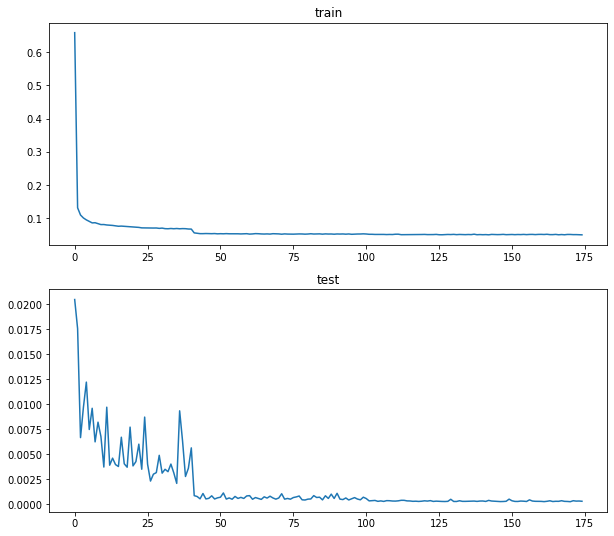

Epoch[175/175] | loss train:0.050553, test:0.000295


In [13]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
lr = 0.001

losses_train = []
losses_test = []
# begin training
for epoch in range(175): 
    if epoch > 40:
        lr = 0.0001
    if epoch > 100:
        lr = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 175, loss_train, loss_val))

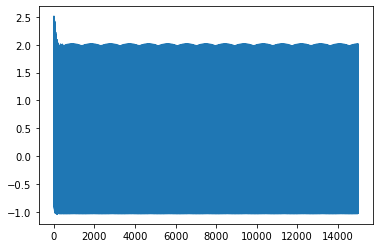

In [16]:
plt.plot(trainx3)

In [27]:
def ShowPredict(train, test):
    train = (train - mean)/std
    train = torch.FloatTensor(train).view(-1)
        
    test = (test - mean)/std
    test = torch.FloatTensor(test).view(-1)
    
    train_inout_seq = create_inout_sequences(train, train_window)
    test_inout_seq = create_inout_sequences(test, train_window)
    train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

    model.eval()

    # predict on the training data, to see how well the model managed to learn and memorize

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    # predict on the validation data, to see how the model does

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))
        
    fig = plt.figure(figsize=(10, 9))
        
    ax_1 = fig.add_subplot(2, 2, 1)
    ax_1.set_title("Predicted train")    
    ax_1.plot(predicted_train[200:500])

    ax_2 = fig.add_subplot(2, 2, 2)
    ax_2.set_title("Train") 
    ax_2.plot(train[220:520])

    ax_3 = fig.add_subplot(2, 2, 3)
    ax_3.set_title("Predicted test") 
    ax_3.plot(predicted_val[200:500])
    
    ax_4 = fig.add_subplot(2, 2, 4)
    ax_4.set_title("Test") 
    ax_4.plot(test[220:520])
    
    plt.show()

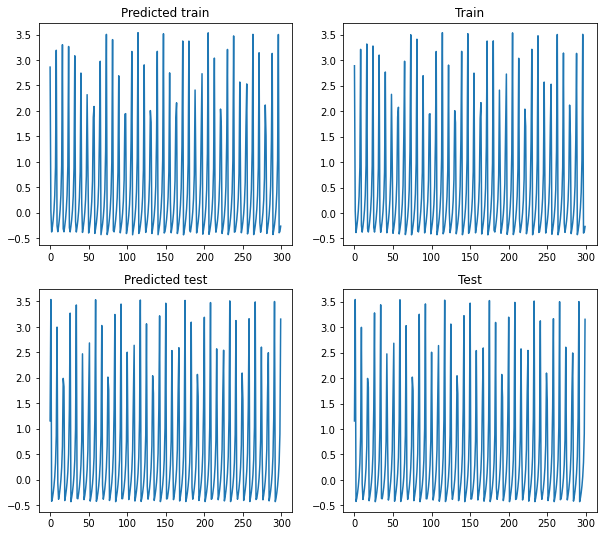

In [28]:
ShowPredict(trainx3, testx3)

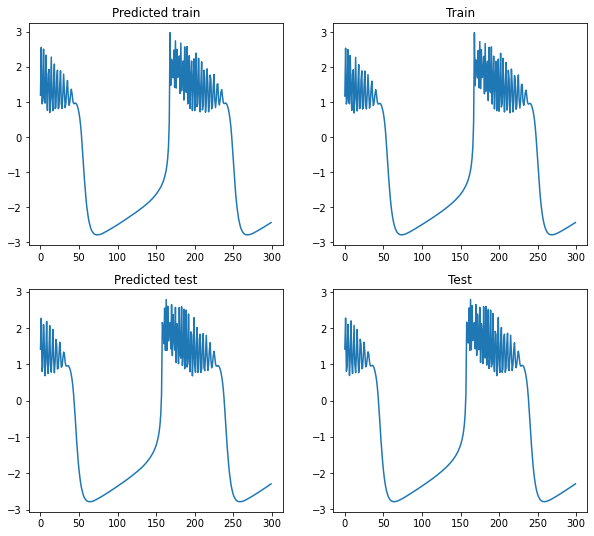

In [29]:
ShowPredict(trainx5, testx5)

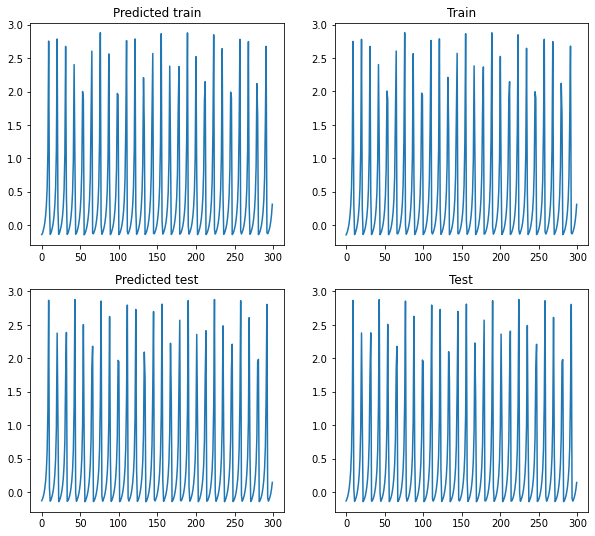

In [30]:
ShowPredict(trainx6, testx6)

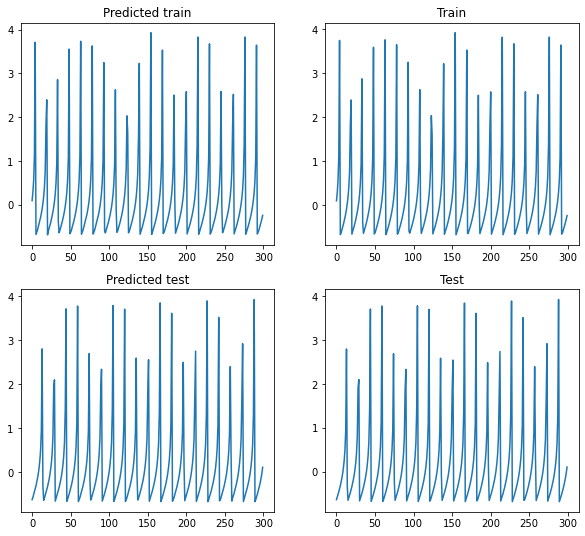

In [31]:
ShowPredict(trainx7, testx7)

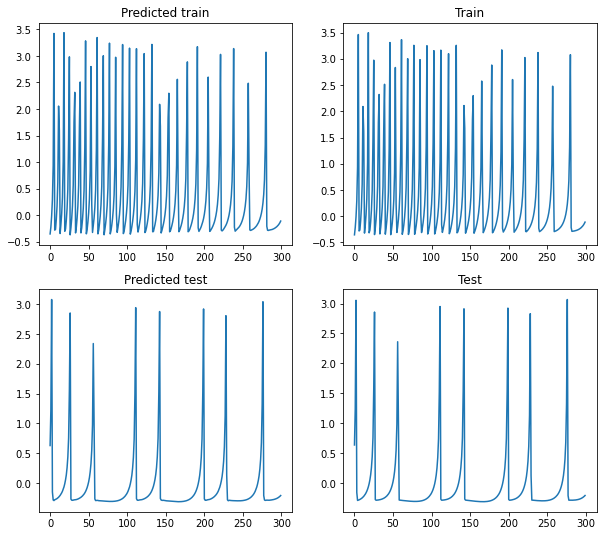

In [32]:
ShowPredict(traingr1, testgr1)

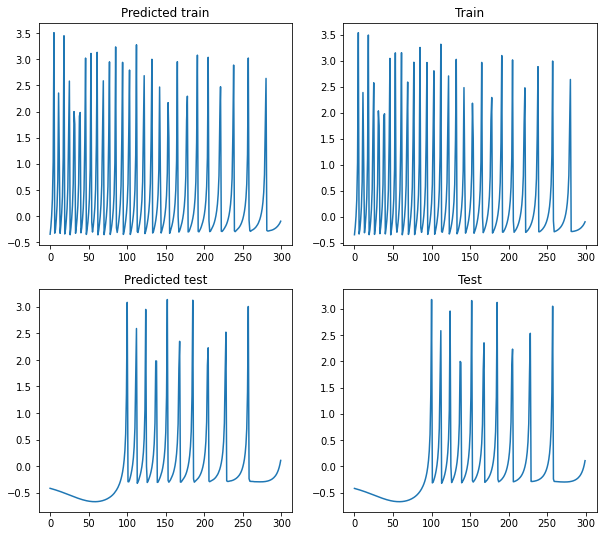

In [33]:
ShowPredict(traingr2, testgr2)

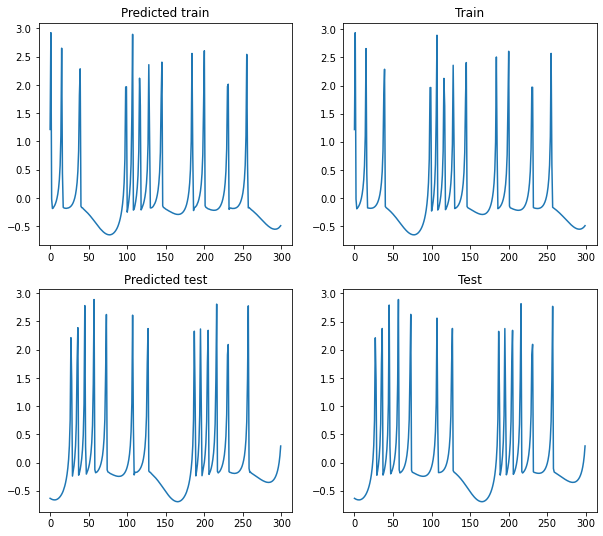

In [34]:
ShowPredict(traingr3, testgr3)

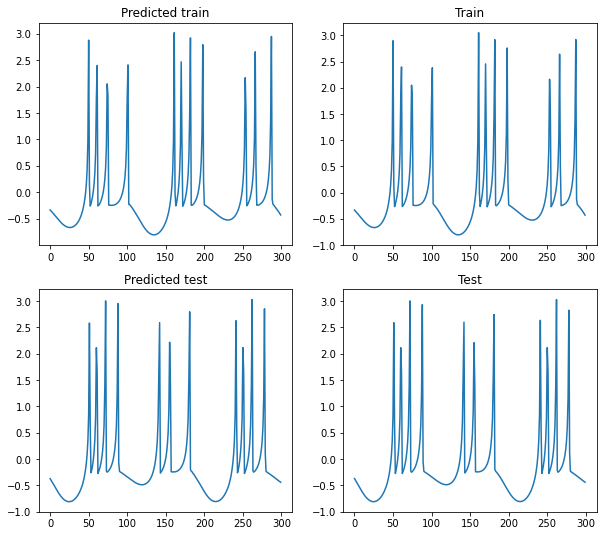

In [35]:
ShowPredict(traingr4, testgr4)

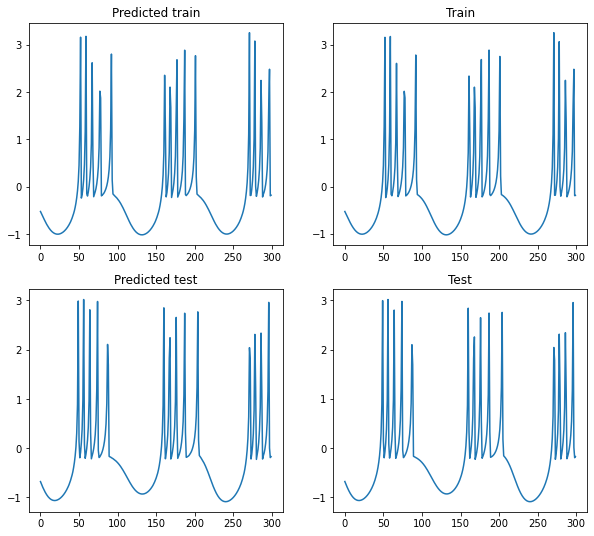

In [36]:
ShowPredict(traingr5, testgr5)

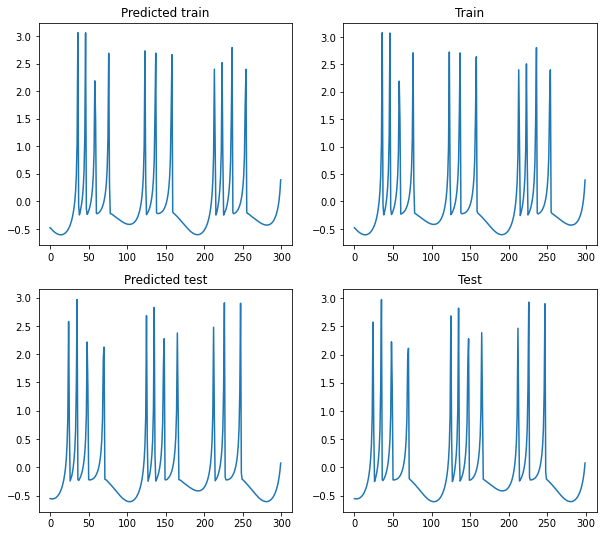

In [37]:
ShowPredict(traingr6, testgr6)